# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import glob

Frame the Problem and Look at the Big Picture
=============================================

1. **Define the objective in business terms:** Developing a machine learning model to predict delays and cancellations and their types 7 days in advance. Customers satisfaction would increase if delays and cancellations could be predicted earlier. This would also cut costs and better prepare airports.
2. **How will your solution be used?** Will be used to predict delays and cancellations to better prepare customers and airports and save money. 
3. **What are the current solutions/workarounds (if any)?** Manually look at weather, historical data, and quick decision making. Delays are known when they occur and not as far in advance to be useful.
4. **How should you frame this problem?** It is a Supervised Multiclassification problem for delays and cancellations and the delays length and the causes of delays and cancellations.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** Accuracy, precision, ROC-AUC, f1 score and recall with focus on recall.
6. **What would be the minimum performance needed to reach the business objective?** Asked for 25% increase would be great.
7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** MNIST and Iris data sets would be useful for experience for classification and multiclass.
8. **Is human expertise available?** Flights can be somewhat predictably predicted but not too great.
9. **How would you solve the problem manually?** Look at trends and weather data. Check for holidays, and how full an airport is. Check if an inbound plane is late as this leads to the next flight being delayed most likely.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** Weather causes delays the most. Some flight paths are more likely to be delayed than others. Some carriers are more likely to be delayed or cancelled as well as some airports are more likely too.

**Posibile Target Labels**
* ARR_DELAY (Arrival Delay): This could be the main label we're trying to predict, as it directly relates to flight performance (whether the flight is on time or delayed).

* CANCELLED (Flight Cancellation): This could also be a target label since we're trying to predict whether a flight will be cancelled or not (binary classification: 0 = not cancelled, 1 = cancelled).

**Posible Feature Extractions** 
Time-based Features:

* Day of the Week: Extract the day of the week from the FL_DATE (Flight Date) to capture patterns like weekend flights being more prone to delays.
* Month and Quarter: Create features based on MONTH and QUARTER to detect seasonal effects, such as more delays during certain months or quarters (e.g., holiday seasons or weather-related issues).
* Time of Day (e.g., Morning, Afternoon, Evening): Can create a categorical feature from CRS_DEP_TIME (Scheduled Departure Time) to analyze whether flights during certain times of day experience more delays.

Categorical Encoding:

* Carrier and Airport Features: Features such as MKT_UNIQUE_CARRIER, OP_CARRIER, ORIGIN, and DEST can be encoded into numerical format using one-hot encoding or label encoding. This can help capture patterns related to specific airlines, routes, or airports that have frequent delays or cancellations.
* Airline's Flight Number: Features like MKT_CARRIER_FL_NUM could be important as they could help identify patterns for specific flight routes (e.g., certain flight numbers having higher delays).

Aggregated Delay Features:

* Total Delays: Create a feature that sums up different delay types like CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY to get a total "cause of delay" metric.
Flight Delay History: Extract patterns from past delays, such as calculating the average delay for a specific flight or airline over the past month or year.

Duration Features:

* Flight Duration: Can use ACTUAL_ELAPSED_TIME and CRS_ELAPSED_TIME to compute the actual duration of the flight and the difference between the actual and scheduled times (e.g., a new feature like DELTA_ELAPSED_TIME).
* Taxi Time Features: TAXI_OUT, WHEELS_OFF, TAXI_IN, WHEELS_ON could be used to capture taxiing times before and after the flight, which can sometimes be an indicator of delays.

Distance-related Features:

* Flight Distance: Could create derived features like the ratio of DISTANCE to ACTUAL_ELAPSED_TIME to understand the speed or efficiency of the flight.

Categorical Interaction Features:

* Carrier-Airport Interaction: Interaction between MKT_CARRIER and ORIGIN or DEST can be useful in understanding how specific carriers perform at certain airports.
* Departure-Arrival Airport Pairing: Create a new feature from combinations of ORIGIN and DEST to understand route-specific behavior.

**Unusable or Irrelevant Features:** 

Features with 100% Missing Data:

* Features such as DIV4_AIRPORT, DIV5_AIRPORT, DIV4_WHEELS_ON, DIV5_WHEELS_ON, etc., are almost entirely missing data (100%). These should be dropped as they won't provide any value for analysis.

Unique Identifiers or Non-Informative Features:

* TAIL_NUM (Tail Number): This is a unique identifier for each aircraft and does not contribute to the prediction of delays or cancellations.
DUP: This feature seems to be a flag or a duplicate flag but is not clear from the data provided. It likely doesn't contribute to the problem.
DIV_AIRPORT_*, DIV_TAIL_NUM, etc., are likely to represent auxiliary features related to diverted flights, but they are mostly missing or redundant in 
their current state.

Features with Nearly All Data Missing:

* Features like SCH_OP_UNIQUE_CARRIER, SCH_OP_CARRIER_AIRLINE_ID, and SCH_OP_CARRIER_FL_NUM have over 99% missing data. These features are not useful in their current state and can likely be dropped.

Unclear Features:

* CANCELLATION_CODE is mostly missing (98.67%), and may not be useful unless a significant portion of data is filled or transformed into something else (like a binary cancellation flag).

Get the Data
============

1. **List the data you need and how much you need:**
    - Flight Delays and Cancellation Data from 2023-2024
    - Weather Data across the country from 2023-2024
2. **Find and document where you can get that data:**
    - The data is available in https://www.transtats.bts.gov/tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r from Jan 2023-Dec 2024
    - open-meteo.com has all weather data needed
3. **Get access authorizations**:
   - Flight data is publically available
   - The weather data is publically available (for non-commercial use, in the real we would need to pay for the weather data to use it commercially)
4. **Create a workspace**: This notebook.
5. **Get the data**: 
    - Download all data from the website month by month and combine them into one.
    - Can get the weather data using the open-meteo.com API
6. **Convert the data to a format you can easily manipulate**:
   - The data is in several CSV files. Would be nicer to have them all in one csv file.
   - The weather data is in a relatively small CSV file.
   - We will create a merged dataset that is ready to load from the two sources.

In [2]:
# Path to your CSV files (adjust accordingly)
#csv_files = glob.glob("/users/badmand/Courses/390 NN/NeuralProject1/cleaned_data.csv")  # Update this path

# Read and merge all CSV files
#df_list = [pd.read_csv(file) for file in csv_files]
#merged_df = pd.concat(df_list, ignore_index=True)

# Save as a Parquet file
#merged_df.to_parquet("flights_2023_2024.parquet", index=False)

#print("Merging completed. Output saved as merged_output.parquet")


In [3]:
#data = pd.read_parquet('flights_2023_2024.parquet')

In [4]:
#weather_data = pd.read_parquet('weather.parquet')

In [5]:
#data["Origin"] = data["Origin"].astype('category')
#data["CRSDepTime"] = pd.to_numeric(data["CRSDepTime"], errors='coerce')
#mins = pd.to_timedelta(data["CRSDepTime"]// 100 * 60 + data["CRSDepTime"] % 100, unit='m')
#data["dep_datetime"] = pd.to_datetime(data["FlightDate"]) + mins

#weather_data['IATA'] = weather_data['IATA'].astype('category')
#weather_data['Date'] = pd.to_datetime(weather_data['date'].apply(lambda x: x.replace(tzinfo=None)))

#data.sort_values(by='dep_datetime', inplace=True)
#weather_data.sort_values(by='Date', inplace=True)

# Ensure both columns have the same categories
#common_categories = list(set(data["Origin"].cat.categories) & set(weather_data["IATA"].cat.categories))
#data["Origin"] = data["Origin"].cat.set_categories(common_categories)
#weather_data["IATA"] = weather_data["IATA"].cat.set_categories(common_categories)

#merged_data = pd.merge_asof(data, weather_data,
                            #left_by='Origin',
                            #left_on='dep_datetime',
                            #right_by='IATA',
                            #right_on='Date',
                            #direction='nearest')

#merged_data.drop(columns=['IATA', 'Date', 'FlightDate'], inplace=True)

#merged_data.to_parquet("merged_data.parquet", index=False)


In [6]:
data = pd.read_parquet('merged_data.parquet')

In [7]:
def split_data(data):
    """
    Split the data into a training and testing set
    """
    return train_test_split(data, test_size=0.1, random_state=42)

train_set, test_set = split_data(data)

In [8]:
# Save the datasets to parquet files to the directory
#train_set.to_parquet('train_set.parquet')
#test_set.to_parquet('test_set.parquet')

In [9]:
# This will rename or variable to make things easier while also freeing up memory by deleting the original data
# The original is still available on disk (so we are indeed working with a copy already)
if 'train_set' in locals():
    data = train_set
    del train_set, test_set # to free up memory
else:
    data = pd.read_parquet('train_set.parquet')

Explore the Data
=============

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13343136 entries, 7944785 to 14802022
Columns: 111 entries, Year to longitude
dtypes: category(1), datetime64[ns](1), datetime64[us, America/New_York](1), float64(69), int64(20), object(19)
memory usage: 11.1+ GB


In [11]:
data.describe()

,Year,Quarter,Month,DayofMonth,DayOfWeek,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,DOT_ID_Operating_Airline,...,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude
count,1.334314e+07,1.334314e+07,1.334314e+07,1.334314e+07,1.334314e+07,1.334314e+07,1.334314e+07,1445.000000,1445.000000,1.334314e+07,...,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07,1.334308e+07
mean,2.023509e+03,2.528795e+00,6.586025e+00,1.577166e+01,3.983610e+00,1.982678e+04,2.551525e+03,20339.435986,5150.642907,1.996522e+04,...,1.874021e+02,1.877872e+02,1.882492e+02,1.894534e+02,1.958706e+01,1.678334e+01,1.663544e+01,1.569130e+01,3.671983e+01,-9.465165e+01
min,2.023000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,20046.000000,3068.000000,1.939300e+04,...,3.924265e-01,3.370337e-01,3.696410e-01,2.938259e-01,0.000000e+00,-3.948050e+01,-3.839550e+01,-3.708050e+01,-1.433100e+01,-1.766428e+02
25%,2.023000e+03,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,1.979000e+04,1.154000e+03,20378.000000,4092.000000,1.979000e+04,...,1.032405e+02,1.046209e+02,1.043494e+02,1.084350e+02,1.080000e+01,1.017800e+01,1.006350e+01,9.409000e+00,3.330780e+01,-1.085430e+02
50%,2.024000e+03,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,1.980500e+04,2.233000e+03,20378.000000,5735.000000,1.993000e+04,...,1.906196e+02,1.916336e+02,1.956111e+02,1.962091e+02,1.728000e+01,1.773150e+01,1.761500e+01,1.693000e+01,3.736260e+01,-8.790480e+01
75%,2.024000e+03,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,1.997700e+04,3.777000e+03,20398.000000,6095.000000,2.036800e+04,...,2.719749e+02,2.713322e+02,2.707252e+02,2.705846e+02,2.628000e+01,2.409350e+01,2.388900e+01,2.280050e+01,4.077720e+01,-8.094310e+01
max,2.024000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.043600e+04,9.887000e+03,20500.000000,6378.000000,2.050000e+04,...,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,1.458000e+02,4.701450e+01,4.671450e+01,4.524900e+01,7.128540e+01,1.457290e+02
std,4.999180e-01,1.106829e+00,3.403234e+00,8.781012e+00,2.007178e+00,2.825302e+02,1.710286e+03,124.611016,1056.853637,3.747930e+02,...,1.004177e+02,9.997807e+01,9.964744e+01,9.880733e+01,1.183799e+01,9.736740e+00,9.708246e+00,9.445267e+00,6.019677e+00,1.856179e+01


In [12]:
data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,...,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude
7944785,2024,1,2,5,1,AA,AA_CODESHARE,19805,AA,4391.0,...,41.185837,38.65983,16.144413,41.98714,15.840000,6.3425,6.1425,3.421000,38.852100,-77.037697
7877591,2024,1,2,1,4,WN,WN,19393,WN,1548.0,...,135.000100,162.58194,209.604350,213.46541,18.720000,8.8315,8.8815,8.383000,39.175400,-76.668297
13655264,2024,4,11,4,1,WN,WN,19393,WN,5305.0,...,191.592150,192.43954,203.962500,207.55272,43.199997,18.9585,18.8085,17.838999,41.785999,-87.752403
10613233,2024,2,6,14,5,DL,DL,19790,DL,2626.0,...,90.000000,180.00000,333.435030,312.95460,1.080000,30.2155,30.0655,29.422000,33.636700,-84.428101
505038,2023,1,1,28,6,AA,AA_CODESHARE,19805,AA,5950.0,...,243.435010,228.01286,236.309900,229.76372,4.680000,3.6435,3.5935,6.793500,35.214001,-80.943100


In [13]:
# There are 20 target columns

# Normal flights (No delay or minor delay below 15 minutes, not cancelled)
data['Normal'] = (data['ArrDelayMinutes'] < 15) & (data['Cancelled'] == 0)

# Carrier Delays
data['CarrierMinor'] = (data['ArrDelayMinutes'].between(15, 60)) & (data['CarrierDelay'] > 0)
data['CarrierMedium'] = (data['ArrDelayMinutes'].between(61, 180)) & (data['CarrierDelay'] > 0)
data['CarrierMajor'] = (data['ArrDelayMinutes'] > 180) & (data['CarrierDelay'] > 0)

# Weather Delays
data['WeatherMinor'] = (data['ArrDelayMinutes'].between(15, 60)) & (data['WeatherDelay'] > 0)
data['WeatherMedium'] = (data['ArrDelayMinutes'].between(61, 180)) & (data['WeatherDelay'] > 0)
data['WeatherMajor'] = (data['ArrDelayMinutes'] > 180) & (data['WeatherDelay'] > 0)

# NAS Delays
data['NASMinor'] = (data['ArrDelayMinutes'].between(15, 60)) & (data['NASDelay'] > 0)
data['NASMedium'] = (data['ArrDelayMinutes'].between(61, 180)) & (data['NASDelay'] > 0)
data['NASMajor'] = (data['ArrDelayMinutes'] > 180) & (data['NASDelay'] > 0)

# Security Delays
data['SecurityMinor'] = (data['ArrDelayMinutes'].between(15, 60)) & (data['SecurityDelay'] > 0)
data['SecurityMedium'] = (data['ArrDelayMinutes'].between(61, 180)) & (data['SecurityDelay'] > 0)
data['SecurityMajor'] = (data['ArrDelayMinutes'] > 180) & (data['SecurityDelay'] > 0)

# Cancellations
data['CarrierCancellation'] = (data['Cancelled'] == 1) & (data['CancellationCode'] == 'A')
data['WeatherCancellation'] = (data['Cancelled'] == 1) & (data['CancellationCode'] == 'B')
data['NASCancellation'] = (data['Cancelled'] == 1) & (data['CancellationCode'] == 'C')
data['SecurityCancellation'] = (data['Cancelled'] == 1) & (data['CancellationCode'] == 'D')

# Late Aircraft Delays
data['LateArrivalMinor'] = (data['ArrDelayMinutes'].between(15, 59)) & (data['LateAircraftDelay'] > 0)
data['LateArrivalMedium'] = (data['ArrDelayMinutes'].between(60, 179)) & (data['LateAircraftDelay'] > 0)
data['LateArrivalMajor'] = (data['ArrDelayMinutes'] >= 180) & (data['LateAircraftDelay'] > 0)

# Convert boolean target columns to numerical (0 or 1)
target_columns = [
    'Normal', 'CarrierMinor', 'CarrierMedium', 'CarrierMajor', 
    'WeatherMinor', 'WeatherMedium', 'WeatherMajor', 
    'NASMinor', 'NASMedium', 'NASMajor', 
    'SecurityMinor', 'SecurityMedium', 'SecurityMajor', 
    'CarrierCancellation', 'WeatherCancellation', 'NASCancellation', 'SecurityCancellation', 
    'LateArrivalMinor', 'LateArrivalMedium', 'LateArrivalMajor'
]

data[target_columns] = data[target_columns].astype(int)

# Create a new categorical column based on the first matching category
#data['Target'] = data[target_columns].idxmax(axis=1)

# Convert to categorical type for efficiency
#data['Target'] = data['Target'].astype('category')

# Drop original 20 columns if needed
#data.drop(columns=target_columns, inplace=True)

# Check the result
#print(data['Target'].value_counts())




In [14]:
# Must then drop a LOT of data (cannot use current flight times to predict future flight times)

# Drop columns that are unavailable when making predictions 7 days ahead
columns_to_drop = [
'DepTime',
'DepDelay',
'DepDelayMinutes',
'DepDel15',
'DepartureDelayGroups',
'TaxiOut',
'WheelsOff',
'WheelsOn',
'TaxiIn',
'ArrTime',
'ArrDelay',
'ArrDelayMinutes',
'ArrDel15',
'ArrivalDelayGroups',
'ActualElapsedTime',
'AirTime',
'Cancelled',
'CancellationCode',
'CarrierDelay',
'WeatherDelay',
'NASDelay',
'SecurityDelay',
'LateAircraftDelay',
'FirstDepTime',
'TotalAddGTime',
'LongestAddGTime',
'Duplicate',
]
    
data = data.drop(columns=columns_to_drop, errors='ignore')

In [27]:
#Show all columns
pd.set_option('display.max_columns', None)
data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Originally_Scheduled_Code_Share_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,IATA_Code_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTimeBlk,CRSArrTime,ArrTimeBlk,CRSElapsedTime,Flights,Distance,DistanceGroup,dep_datetime,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation_probability,apparent_temperature,precipitation,rain,showers,snowfall,snow_depth,soil_temperature_0cm,soil_moisture_0_to_1cm,vapour_pressure_deficit,et0_fao_evapotranspiration,evapotranspiration,visibility,cloud_cover_mid,cloud_cover_high,cloud_cover_low,cloud_cover,surface_pressure,weather_code,pressure_msl,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,latitude,longitude,Normal,CarrierMinor,CarrierMedium,CarrierMajor,WeatherMinor,WeatherMedium,WeatherMajor,NASMinor,NASMedium,NASMajor,SecurityMinor,SecurityMedium,SecurityMajor,CarrierCancellation,WeatherCancellation,NASCancellation,SecurityCancellation,LateArrivalMinor,LateArrivalMedium,LateArrivalMajor
7944785,2024,1,2,5,1,AA,AA_CODESHARE,19805,AA,4391.0,None,NaN,None,NaN,YX,20452,YX,N423YX,4391.0,11278,1127805,30852,DCA,"Washington, DC",VA,51,Virginia,38,14307,1430706,30721,PVD,"Providence, RI",RI,44,Rhode Island,15,1158,1100-1159,1322,1300-1359,84.0,1.0,356.0,2,2024-02-05 11:58:00,2024-02-05 12:00:00-05:00,8.587001,41.0,-3.935944,NaN,5.081573,0.0,0.0,0.0,0.0,0.0,10.021000,0.283,0.659964,0.258151,0.0,48400.0,0.0,0.0,0.0,0.0,1013.2313,0.0,1013.6,7.653705,9.220499,14.536208,14.529915,41.185837,38.65983,16.144413,41.98714,15.840000,6.3425,6.1425,3.421000,38.852100,-77.037697,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7877591,2024,1,2,1,4,WN,WN,19393,WN,1548.0,None,NaN,None,NaN,WN,19393,WN,N930WN,1548.0,10821,1082106,30852,BWI,"Baltimore, MD",MD,24,Maryland,35,12889,1288904,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,1845,1800-1859,2125,2100-2159,340.0,1.0,2106.0,9,2024-02-01 18:45:00,2024-02-01 19:00:00-05:00,7.254500,63.0,0.674866,NaN,4.419982,0.0,0.0,0.0,0.0,0.0,4.733000,0.295,0.378043,0.010511,-0.0,27300.0,2.0,6.0,0.0,6.0,1007.7559,0.0,1012.8,5.600286,19.242327,18.595108,25.460936,135.000100,162.58194,209.604350,213.46541,18.720000,8.8315,8.8815,8.383000,39.175400,-76.668297,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
13655264,2024,4,11,4,1,WN,WN,19393,WN,5305.0,None,NaN,None,NaN,WN,19393,WN,N8930S,5305.0,13232,1323202,30977,MDW,"Chicago, IL",IL,17,Illinois,41,11697,1169706,32467,FLL,"Fort Lauderdale, FL",FL,12,Florida,33,1710,1700-1759,2110,2100-2159,180.0,1.0,1167.0,5,2024-11-04 17:10:00,2024-11-04 17:00:00-05:00,18.769500,87.0,16.559889,12.0,18.970978,0.0,0.0,0.0,0.0,0.0,18.289000,0.299,0.281652,0.043477,0.0,15200.0,0.0,98.0,100.0,100.0,988.7233,3.0,1010.2,14.332341,25.068514,36.189270,37.356830,191.592150,192.43954,203.962500,207.55272,43.199997,18.9585,18.8085,17.838999,41.785999,-87.752403,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10613233,2024,2,6,14,5,DL,DL,19790,DL,2626.0,None,NaN,None,NaN,DL,19790,DL,N390DA,2626.0,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,11003,1100303,31003,CID,"Cedar Rapids/Iowa City, IA",IA,19,Iowa,61,2048,2000-2059,2153,2100-2159,125.0,1.0,694.0,3,2024-06-14 20:48:00,2024-06-14 21:00:00-04:00,29.565500,44.0,16.029896,NaN,31.526085,0.0,0.0,0.0,0.0,0.0,25.372002,0.205,2.316697,0.016984,-0.0,44000.0,

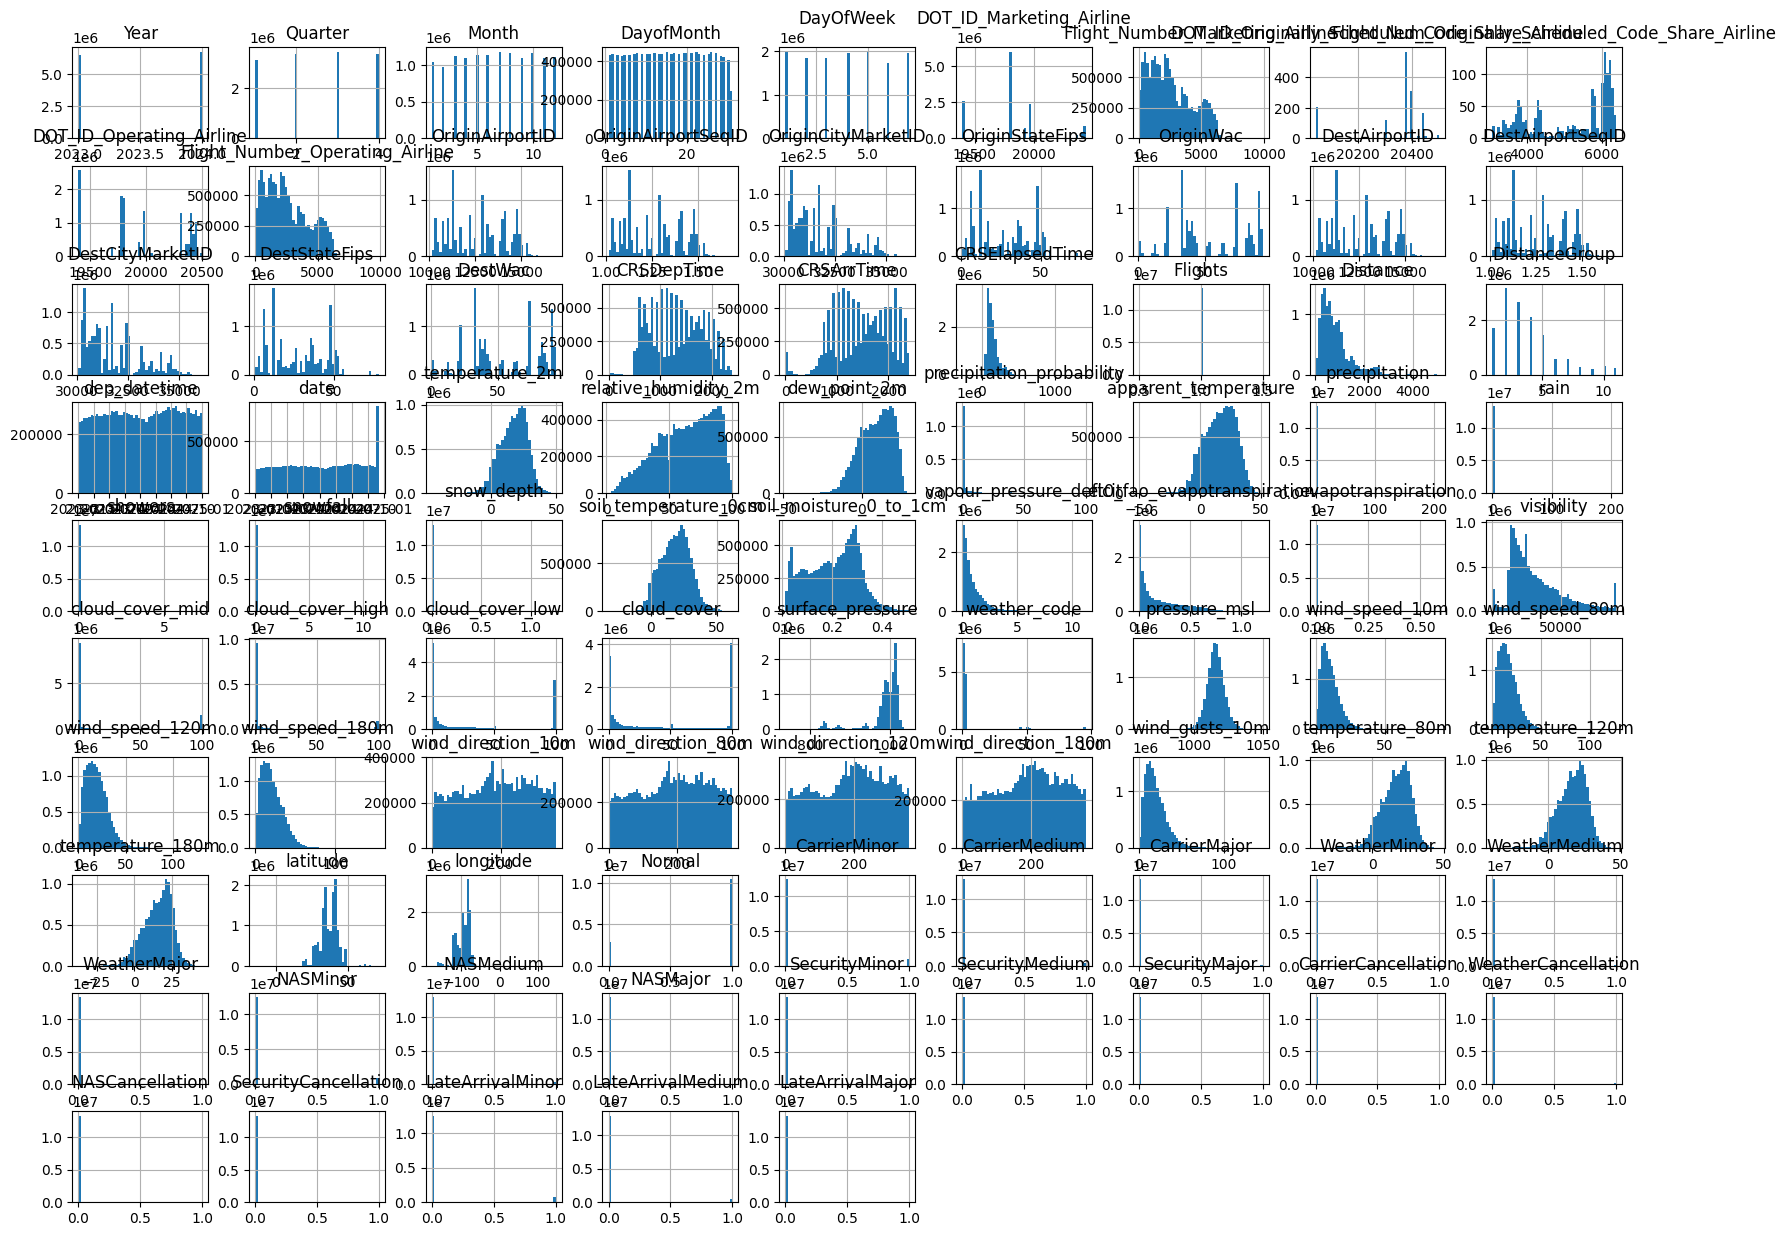

In [16]:
#Plot all numerical data histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

# Prepare the Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [ ]:
# Define target variable (e.g., Predicting departure delay)
target = ""  # Unsure of what to put here. Does he want all 20 of the different delay types?

# Feature Selection: Exclude columns with high missing values and non-useful ones
drop_cols = [
    "FL_DATE", "TAIL_NUM", "CANCELLATION_CODE", "DUP",
    "SCH_OP_UNIQUE_CARRIER", "SCH_OP_CARRIER_AIRLINE_ID", "SCH_OP_CARRIER",
    "FIRST_DEP_TIME", "TOTAL_ADD_GTIME", "LONGEST_ADD_GTIME",
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"
]

data = data.drop(columns=drop_cols)

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Identify numerical and categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# Define preprocessing steps
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing values with median
    ("scaler", StandardScaler())  # Standardize numerical features
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical variables
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# Create pipeline with Random Forest
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

KeyError: "['FL_DATE', 'TAIL_NUM', 'CANCELLATION_CODE', 'DUP', 'SCH_OP_UNIQUE_CARRIER', 'SCH_OP_CARRIER_AIRLINE_ID', 'SCH_OP_CARRIER', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'] not found in axis"

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
pipeline.fit(X_train, y_train)

# Evaluate
print("Training Accuracy:", pipeline.score(X_train, y_train))
print("Test Accuracy:", pipeline.score(X_test, y_test))